In [1]:
!pip install numpy pandas tensorflow opencv-python matplotlib scikit-learn
!pip install keras-ocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00


In [2]:
#code to extract the license_plates_recognition_train.zip
import zipfile

zip_path = "/content/license_plates_recognition_train.zip"
extract_path = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file in zip_ref.namelist():
        try:
            zip_ref.extract(file, extract_path)
            print(f"Extracted: {file}")
        except Exception as e:
            print(f"Error extracting {file}: {e}")


Extracted: license_plates_recognition_train/0.jpg
Extracted: license_plates_recognition_train/1.jpg
Extracted: license_plates_recognition_train/10.jpg
Extracted: license_plates_recognition_train/100.jpg
Extracted: license_plates_recognition_train/101.jpg
Extracted: license_plates_recognition_train/102.jpg
Extracted: license_plates_recognition_train/103.jpg
Extracted: license_plates_recognition_train/104.jpg
Extracted: license_plates_recognition_train/105.jpg
Extracted: license_plates_recognition_train/106.jpg
Extracted: license_plates_recognition_train/107.jpg
Extracted: license_plates_recognition_train/108.jpg
Extracted: license_plates_recognition_train/109.jpg
Extracted: license_plates_recognition_train/11.jpg
Extracted: license_plates_recognition_train/110.jpg
Extracted: license_plates_recognition_train/111.jpg
Extracted: license_plates_recognition_train/112.jpg
Extracted: license_plates_recognition_train/113.jpg
Extracted: license_plates_recognition_train/114.jpg
Extracted: license

In [3]:
!pip install opencv-python
!pip install pytesseract
!sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (3,384 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [6]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Reshape, Bidirectional, LSTM, Input, TimeDistributed
from tensorflow.keras.models import Model

# Load CSV file
df = pd.read_csv("/content/Licplatesrecognition_train.csv")

# Define image directory
image_dir = "/content/license_plates_recognition_train/"

# Character mapping (digits + 'T' for تونس)
char_map = {str(i): i for i in range(10)}  # Map digits 0-9
char_map["T"] = 10  # Map 'T' (for "تونس")
num_classes = len(char_map) + 1  # Extra class for padding

# Reverse mapping (for decoding predictions)
inv_char_map = {v: k for k, v in char_map.items()}

# Function to process text
def process_text(text):
    text = text.replace("تونس", "T")  # Replace Arabic word with 'T'
    return [char_map[char] for char in text if char in char_map]  # Convert to indices

# Prepare training data
X, y = [], []
for _, row in df.iterrows():
    img_path = os.path.join(image_dir, row["img_id"])

    # Read and preprocess image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 32))  # Resize for consistency
    img = img / 255.0  # Normalize
    X.append(img)

    # Process text label
    y.append(process_text(row["text"]))

# Convert to numpy arrays
X = np.array(X).reshape(-1, 32, 128, 1)  # Add channel dimension

# Handle variable-length labels
max_length = max(len(label) for label in y)
y_padded = pad_sequences(y, maxlen=max_length, padding='post', value=num_classes-1)  # Pad with last class

# Convert labels to categorical (multi-digit recognition)
y_categorical = np.array([to_categorical(label, num_classes=num_classes) for label in y_padded])

# Define CNN + BiLSTM model
inputs = Input(shape=(32, 128, 1))

# CNN Layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Reshape for LSTM
x = Reshape((8, -1))(x)  # Automatically adjust second dimension

# BiLSTM Layers
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)

# TimeDistributed Dense Layer
x = TimeDistributed(Dense(num_classes, activation='softmax'))(x)

# Define model
model = Model(inputs, x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X, y_categorical, epochs=50, batch_size=16, validation_split=0.1)

# Save model
model.save("best1.h5")
print("Model training complete and saved as Vinoth_LicensePlateRecognition.h5")


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 251ms/step - accuracy: 0.2464 - loss: 2.3164 - val_accuracy: 0.3014 - val_loss: 2.1155
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 232ms/step - accuracy: 0.3156 - loss: 2.0719 - val_accuracy: 0.3056 - val_loss: 1.9691
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - accuracy: 0.3151 - loss: 1.9834 - val_accuracy: 0.3167 - val_loss: 1.9246
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - accuracy: 0.3166 - loss: 1.9419 - val_accuracy: 0.3250 - val_loss: 1.8784
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 230ms/step - accuracy: 0.3254 - loss: 1.8748 - val_accuracy: 0.3236 - val_loss: 1.9132
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - accuracy: 0.3284 - loss: 1.8851 - val_accuracy: 0.3292 - val_loss: 1.8432
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - accuracy: 0.3469 - loss: 1.7938 - val_accuracy: 0.3347 - val_loss: 1.8470
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step - accuracy: 0.3508 - loss: 1.7800 - val_accu

Model training complete and saved as Vinoth_LicensePlateRecognition.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step


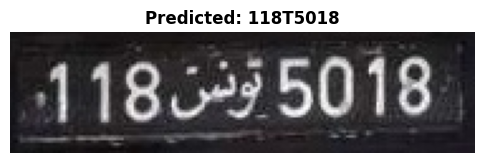

Predicted License Plate: 118T5018


In [7]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Load trained model
model = tf.keras.models.load_model("best1.h5")

# Define character mapping (digits + 'T' for تونس)
char_map = {str(i): i for i in range(10)}  # Map digits 0-9
char_map["T"] = 10  # Map 'T' (for "تونس")
inv_char_map = {v: k for k, v in char_map.items()}  # Reverse mapping

# Preprocess input image
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    img = cv2.resize(img, (128, 32))  # Resize
    img = img / 255.0  # Normalize
    img = img.reshape(1, 32, 128, 1)  # Reshape for model input
    return img, cv2.imread(img_path)  # Return original image for display

# Decode prediction
def decode_prediction(pred):
    pred_classes = np.argmax(pred, axis=-1)  # Get predicted indices
    decoded_text = ''.join(inv_char_map.get(idx, '') for idx in pred_classes)  # Convert indices to characters
    return decoded_text.replace("T", "T")  # Ensure 'T' is properly mapped

# Test image path
test_img_path = "/content/license_plates_recognition_train/126.jpg"

# Preprocess test image
input_img, original_img = preprocess_image(test_img_path)

# Predict
predicted_output = model.predict(input_img)

# Decode
final_text = decode_prediction(predicted_output[0])

# Display image with prediction
plt.figure(figsize=(6, 4))
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"Predicted: {final_text}", fontsize=12, fontweight="bold")
plt.show()

print("Predicted License Plate:", final_text)
